In [52]:
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split
import numpy as np
import torchaudio
import torch
import random

Load data files

In [53]:
train_df = pd.read_csv('./new_train.csv', index_col=0)
val_df = pd.read_csv('./new_validation.csv', index_col=0)
test_df = pd.read_csv('./new_test.csv', index_col=0)

Combine all of the data into single data frame

In [54]:
df = pd.concat([train_df, val_df, test_df], axis=0)

<Axes: >

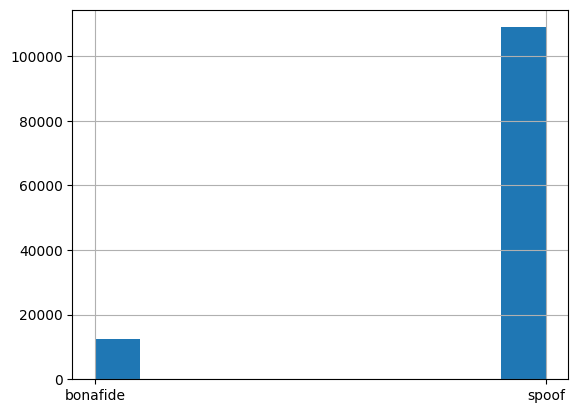

In [55]:
df['class'].hist()

In [56]:
def get_duration_librosa(file_path):
   audio_data, sample_rate = librosa.load(file_path)
   duration = librosa.get_duration(y=audio_data, sr=sample_rate)
   return duration

In [57]:
df['duration'] = df['filepath'].map(lambda path: get_duration_librosa(path))

<Axes: >

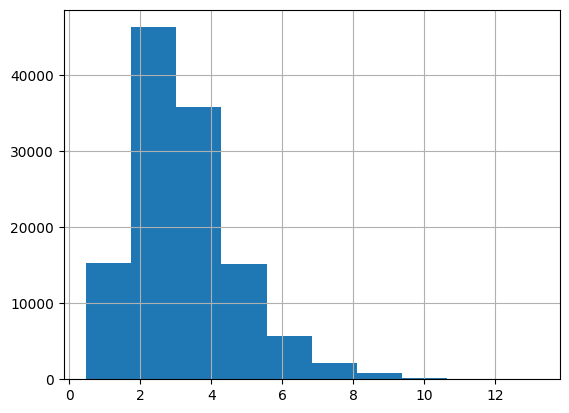

In [58]:
df['duration'].hist()

In [59]:
filtered_df = df[df['duration'] >= 2]
filtered_df = filtered_df.reset_index(drop=True)
filtered_df = filtered_df.drop(filtered_df[filtered_df['class'] == 'spoof'].sample(frac=.6).index)

In [60]:
filtered_df['class'].value_counts()

class
spoof       34452
bonafide    11982
Name: count, dtype: int64

In [61]:
11982 / (11982 + 34452)

0.2580436748933971

<Axes: >

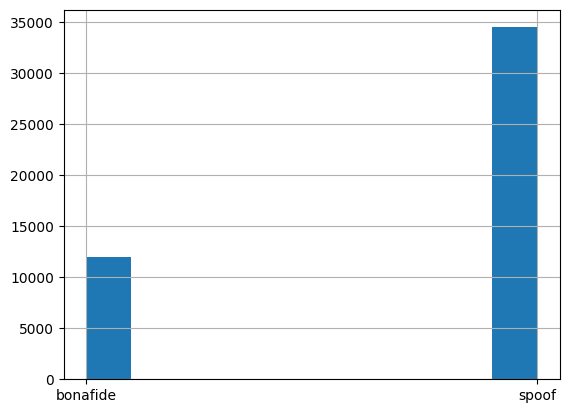

In [62]:
filtered_df['class'].hist()

In [63]:
filtered_df = filtered_df.drop(columns=['duration'])

Augment Data

In [64]:
def augment_noise(path, save_path): 
    noise_factor = np.random.uniform(0.002, 0.021)
    original_audio, sample_rate = torchaudio.load(path)
    # compute noise from sample
    white_noise = np.random.randn(len(original_audio)) * noise_factor
    # apply noise to sample
    augmented_audio = original_audio + white_noise
    # save audio
    file_name = path.split('/')[-1]
    save_file = save_path + 'AUG_N_' + file_name
    torchaudio.save(save_file, augmented_audio, sample_rate=sample_rate, format='flac')
    return save_file, augmented_audio

def augment_shift(path, save_path): 
    shift_amt = np.random.randint(5000, 10001)
    original_audio, sample_rate = torchaudio.load(path)
    # shift audio
    augmented_audio = torch.Tensor(np.roll(original_audio, shift_amt))
    # save audio
    file_name = path.split('/')[-1]
    save_file = save_path + 'AUG_S_' + file_name
    torchaudio.save(save_file, augmented_audio, sample_rate=sample_rate, format='flac')
    return save_file, augmented_audio

def augment_pitch(path, save_path): 
    pitch_factor = np.random.randint(1, 5)
    original_audio, sample_rate = torchaudio.load(path)
    numpy_audio = np.array(original_audio)
    # change pitch
    augmented_audio = torch.Tensor(librosa.effects.pitch_shift(numpy_audio, sr=sample_rate, n_steps=pitch_factor))
    # save audio
    file_name = path.split('/')[-1]
    save_file = save_path + 'AUG_P_' + file_name
    torchaudio.save(save_file, augmented_audio, sample_rate=sample_rate, format='flac')
    return save_file, augmented_audio

def select_augmentation(path, save_dir):
    selection = np.random.randint(0, 3)
    
    if selection == 0:
        return augment_noise(path, save_dir)
    elif selection == 1:
        return augment_shift(path, save_dir)
    else: 
        return augment_pitch(path, save_dir)

In [65]:
bonafide_df = filtered_df[filtered_df['class'] == 'bonafide']
bonafide_paths = list(bonafide_df['filepath'])
bonafide_df

,filepath,class
0,D:/CSC 5651/asvspoof2019/LA_T_1138215.flac,bonafide
1,D:/CSC 5651/asvspoof2019/LA_T_1271820.flac,bonafide
2,D:/CSC 5651/asvspoof2019/LA_T_1272637.flac,bonafide
3,D:/CSC 5651/asvspoof2019/LA_T_1276960.flac,bonafide
4,D:/CSC 5651/asvspoof2019/LA_T_1341447.flac,bonafide
...,...,...
98088,D:/CSC 5651/asvspoof2019/LA_E_9017208.flac,bonafide
98090,D:/CSC 5651/asvspoof2019/LA_E_7055986.flac,bonafide
98093,D:/CSC 5651/asvspoof2019/LA_E_6708601.flac,bonafide
98108,D:/CSC 5651/asvspoof2019/LA_E_1665632.flac,bonafide


In [66]:
augmented_samples = []
for sample in bonafide_paths:
    augmented_path, _ = select_augmentation(sample, 'D:/CSC 5651/augmented_bonafide_samples/')
    augmented_samples.append([augmented_path, 'bonafide'])

augmented_df = pd.DataFrame(augmented_samples, columns=['filepath', 'class'])
augmented_df

,filepath,class
0,D:/CSC 5651/augmented_bonafide_samples/AUG_P_L...,bonafide
1,D:/CSC 5651/augmented_bonafide_samples/AUG_S_L...,bonafide
2,D:/CSC 5651/augmented_bonafide_samples/AUG_P_L...,bonafide
3,D:/CSC 5651/augmented_bonafide_samples/AUG_S_L...,bonafide
4,D:/CSC 5651/augmented_bonafide_samples/AUG_N_L...,bonafide
...,...,...
11977,D:/CSC 5651/augmented_bonafide_samples/AUG_N_L...,bonafide
11978,D:/CSC 5651/augmented_bonafide_samples/AUG_S_L...,bonafide
11979,D:/CSC 5651/augmented_bonafide_samples/AUG_S_L...,bonafide
11980,D:/CSC 5651/augmented_bonafide_samples/AUG_S_L...,bonafide


In [67]:
filtered_df = pd.concat([filtered_df, augmented_df])
filtered_df

,filepath,class
0,D:/CSC 5651/asvspoof2019/LA_T_1138215.flac,bonafide
1,D:/CSC 5651/asvspoof2019/LA_T_1271820.flac,bonafide
2,D:/CSC 5651/asvspoof2019/LA_T_1272637.flac,bonafide
3,D:/CSC 5651/asvspoof2019/LA_T_1276960.flac,bonafide
4,D:/CSC 5651/asvspoof2019/LA_T_1341447.flac,bonafide
...,...,...
11977,D:/CSC 5651/augmented_bonafide_samples/AUG_N_L...,bonafide
11978,D:/CSC 5651/augmented_bonafide_samples/AUG_S_L...,bonafide
11979,D:/CSC 5651/augmented_bonafide_samples/AUG_S_L...,bonafide
11980,D:/CSC 5651/augmented_bonafide_samples/AUG_S_L...,bonafide


<Axes: >

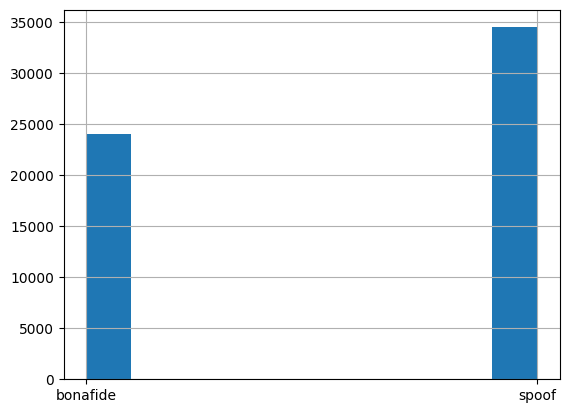

In [68]:
filtered_df['class'].hist()

In [69]:
filtered_df['class'].value_counts()

class
spoof       34452
bonafide    23964
Name: count, dtype: int64

In [70]:
filtered_df.to_csv('./full_dataset.csv')

In [71]:
for index, row in filtered_df.iterrows():
    audio, sr = torchaudio.load(row['filepath'])
    save_path = './asvspoof_full_dataset_augment/' + row['class'] + '/' + row['filepath'].split('/')[-1]
    torchaudio.save(save_path, audio, sample_rate=sr, format='flac')


In [72]:
filtered_export = filtered_df
filtered_export['filepath'] = filtered_export['filepath'].map(lambda path : path.split('/')[-1])
filtered_export['filepath'] = filtered_df['class'] + '/' + filtered_df['filepath']
filtered_export.to_csv('./asvspoof_full_dataset_augment/dataset_labels.csv', index=False)